In [1]:
import pandas as pd
import numpy as np

from datetime import datetime, date
from functools import reduce

In [2]:
# Need to be able to see all columns
pd.set_option('display.max_columns', 999)

In [3]:
police = pd.read_csv("./data/police_sta.csv").add_prefix("police_")
fire = pd.read_csv("./data/fire_dept.csv").add_prefix("fire_")
community = pd.read_csv("./data/community_centers.csv").add_prefix("community_")
parks = pd.read_csv("./data/parks.csv").add_prefix("parks_")
crime = pd.read_csv("./data/crime.csv", low_memory=False).add_prefix("crime_")

crime.name = "crime"
police.name = "police"
fire.name = "fire"
community.name = "community"
parks.name = "parks"

In [4]:
humidity = pd.read_csv("./data/weather/humidity.csv")
temp = pd.read_csv("./data/weather/temperature.csv")
pressure = pd.read_csv("./data/weather/pressure.csv")
weather_descript = pd.read_csv("./data/weather/weather_description.csv")
wind_dir = pd.read_csv("./data/weather/wind_direction.csv")
wind_speed = pd.read_csv("./data/weather/wind_speed.csv")

humidity.name = "humidity"
temp.name = "temperature"
pressure.name = "pressure"
weather_descript.name = "weather_description"
wind_dir.name = "wind_direction"
wind_speed.name = "wind_speed"

In [5]:
datasets = [crime, police, fire, community, parks, humidity, temp, pressure, weather_descript, wind_dir, wind_speed]

In [6]:
for df in datasets:
    # Some of the datasets have Lat/Long as Y/X, which can be confusing
    # They also have longcoord and latcoord, but they're unsigned, so dropping them
    # Regex is to avoid partial matching
    df.columns = df.columns.str.replace("^[X]", "long", regex=True)
    df.columns = df.columns.str.replace("^[Y]", "lat", regex=True)
    df.drop(list(df.filter(regex="coord")), axis = 1, inplace=True)
    
    # Makes typing easier
    df.columns = [x.lower() for x in df.columns]

In [7]:
# Renaming for consistency
crime = crime.rename({"crime_occurred_on_date":"datetime"}, axis=1)

In [8]:
crime[["crime_offense_code", "crime_offense_description"]].groupby("crime_offense_code").sum()

,crime_offense_description
crime_offense_code,
111,"MURDER, NON-NEGLIGIENT MANSLAUGHTERMURDER, NON..."
112,KILLING OF FELON BY POLICE
121,MANSLAUGHTER - VEHICLE - NEGLIGENCEMANSLAUGHTE...
123,MANSLAUGHTER - NON-VEHICLE - NEGLIGENCEMANSLAU...
301,ROBBERY - STREETROBBERY - STREETROBBERY - STRE...
...,...
3811,M/V ACCIDENT - INVOLVING BICYCLE - NO INJURYM/...
3820,M/V ACCIDENT INVOLVING PEDESTRIAN - INJURYM/V ...
3821,M/V ACCIDENT - INVOLVING PEDESTRIAN - NO INJUR...


In [9]:
violent_list = [111, 301, 311, 315, 335, 339, 349, 351, 361, 
                371,381, 402, 403, 404, 413, 423, 432, 801, 
                802, 803, 1610, 1620, 2010, 2511, 2611]
manslaughter_list = [121, 123]
police_homicide_list = [112]
suicide_list = [3008]
drug_medical_assist_list = [1830, 1831, 1832]
removed_crimes_list = [121, 123, 670, 735, 770, 2003, 2004, 2005,
                       2900, 2905, 2906, 2907, 2910, 2914, 
                       3001, 3002, 3004, 3006, 3007] # and anything > 3008
all_other_removed_crimes_list = [x for x in crime.crime_offense_code if x > 3008]

non_violent_creation_list = violent_list + police_homicide_list + suicide_list + \
                            drug_medical_assist_list + removed_crimes_list + \
                            manslaughter_list + all_other_removed_crimes_list
# This is a set to reduce its size, as we only need one entry for each to filter against
non_violent_creation_list = set(non_violent_creation_list)

non_violent_crimes = crime.loc[~crime.crime_offense_code.isin(non_violent_creation_list)]
violent_crimes = crime.loc[crime.crime_offense_code.isin(violent_list)]
manslaughter = crime.loc[crime.crime_offense_code.isin(manslaughter_list)]
police_homicides = crime.loc[crime.crime_offense_code.isin(police_homicide_list)]
suicides = crime.loc[crime.crime_offense_code.isin(suicide_list)]
drug_medical_assists = crime.loc[crime.crime_offense_code.isin(drug_medical_assist_list)]

combined_crimes = crime.loc[~crime.crime_offense_code.isin(all_other_removed_crimes_list)]
combined_crimes = crime.loc[~crime.crime_offense_code.isin(removed_crimes_list)]

In [10]:
bos_weather = []
for df in [humidity, temp, pressure, weather_descript, wind_dir, wind_speed]:
    df = df.rename({"boston":df.name}, axis=1)
    bos_weather.append(df)

In [11]:
# Same as a SQL inner join
weather = reduce(lambda left,right: pd.merge(left,right,on=["datetime"], how="inner"), bos_weather)
weather.drop(weather.filter(regex="[Uu]nnamed"), axis=1, inplace=True)
weather.rename(columns={'boston':'weather_description'}, inplace=True)
# First row is NaN due to the join, drop it
weather.drop(weather.index[0], inplace=True)

In [12]:
weather.head()

,datetime,humidity,temperature,pressure,weather_description,wind_direction,wind_speed
1,2012-10-01 13:00:00,68.0,57.236000,1014.0,sky is clear,60.0,3.0
2,2012-10-01 14:00:00,68.0,57.264966,1014.0,few clouds,60.0,3.0
3,2012-10-01 15:00:00,68.0,57.347009,1014.0,few clouds,60.0,3.0
4,2012-10-01 16:00:00,68.0,57.429052,1014.0,few clouds,60.0,3.0
5,2012-10-01 17:00:00,68.0,57.511095,1014.0,few clouds,61.0,3.0


In [13]:
weather.describe()

,humidity,temperature,pressure,wind_direction,wind_speed
count,44804.000000,45250.000000,45246.000000,45252.000000,45252.000000
mean,77.375301,51.133681,1019.861314,184.915562,3.380889
std,18.750190,17.644498,9.548220,107.763589,2.277266
min,11.000000,-10.498000,978.000000,0.000000,0.000000
25%,65.000000,37.292000,1014.000000,80.000000,2.000000
50%,81.000000,51.769850,1019.000000,210.000000,3.000000
75%,93.000000,65.246000,1026.000000,272.000000,5.000000
max,100.000000,94.730000,1054.000000,360.000000,20.000000


In [14]:
weather.fillna(method="ffill", inplace=True)
weather.isna().any()

datetime               False
humidity               False
temperature            False
pressure               False
weather_description    False
wind_direction         False
wind_speed             False
dtype: bool

In [15]:
# Need to clean up datetime a bit for the next merge

# Ensure they're in datetime64 format
crime["datetime"] = pd.to_datetime(crime["datetime"].str.replace(".", ":"))
weather["datetime"] = pd.to_datetime(weather["datetime"].str.replace(".", ":"))

# Sort by date
crime.sort_values(by="datetime", inplace=True)
weather.sort_values(by="datetime", inplace=True)

In [16]:
weather.transpose().head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,...,44754,44755,44756,44757,44758,44759,44760,44761,44762,44763,44764,44765,44766,44767,44768,44769,44770,44771,44772,44773,44774,44775,44776,44777,44778,44779,44780,44781,44782,44783,44784,44785,44786,44787,44788,44789,44790,44791,44792,44793,44794,44795,44796,44797,44798,44799,44800,44801,44802,44803,44804,44805,44806,44807,44808,44809,44810,44811,44812,44813,44814,44815,44816,44817,44818,44819,44820,44821,44822,44823,44824,44825,44826,44827,44828,44829,44830,44831,44832,44833,44834,44835,44836,44837,44838,44839,44840,44841,44842,44843,44844,44845,44846,44847,44848,44849,44850,44851,44852,44853,44854,44855,44856,44857,44858,44859,44860,44861,44862,44863,44864,44865,44866,44867,44868,44869,44870,44871,44872,44873,44874,44875,44876,44877,44878,44879,44880,44881,44882,44883,44884,44885,44886,44887,44888,44889,44890,44891,44892,44893,44894,44895,44896,44897,44898,44899,44900,44901,44902,44903,44904,44905,44906,44907,44908,44909,44910,44911,44912,44913,44914,44915,44916,44917,44918,44919,44920,44921,44922,44923,44924,44925,44926,44927,44928,44929,44930,44931,44932,44933,44934,44935,44936,44937,44938,44939,44940,44941,44942,44943,44944,44945,44946,44947,44948,44949,44950,44951,44952,44953,44954,44955,44956,44957,44958,44959,44960,44961,44962,44963,44964,44965,44966,44967,44968,44969,44970,44971,44972,44973,44974,44975,44976,44977,44978,44979,44980,44981,44982,44983,44984,44985,44986,44987,44988,44989,44990,44991,44992,44993,44994,44995,44996,44997,44998,44999,45000,45001,45002,45003,45004,45005,45006,45007,45008,45009,45010,45011,45012,45013,45014,45015,45016,45017,45018,45019,45020,45021,45022,45023,45024,45025,45026,45027,45028,45029,45030,45031,45032,45033,45034,45035,45036,45037,45038,45039,45040,45041,45042,45043,45044,45045,45046,45047,45048,45049,45050,45051,45052,45053,45054,45055,45056,45057,45058,45059,45060,45061,45062,45063,45064,45065,45066,45067,45068,45069,45070,45071,45072,45073,45074,45075,45076,45077,45078,45079,45080,45081,45082,45083,45084,45085,45086,45087,45088,45089,45090,45091,45092,45093,45094,45095,45096,45097,45098,45099,45100,45101,45102,45103,45104,4

In [17]:
violent_crimes.head()

,crime_incident_number,crime_offense_code,crime_offense_code_group,crime_offense_description,crime_district,crime_reporting_area,crime_shooting,datetime,crime_year,crime_month,crime_day_of_week,crime_hour,crime_ucr_part,crime_street,crime_lat,crime_long,crime_location
6,I192078638,801,Simple Assault,ASSAULT - SIMPLE,A1,75,NaN,2019-09-29 04:46:00,2019,9,Sunday,4,Part Two,CAUSEWAY ST,42.364331,-71.063193,"(42.36433126, -71.06319318)"
19,I192078613,423,Aggravated Assault,ASSAULT - AGGRAVATED,A7,17,NaN,2019-09-29 02:30:00,2019,9,Sunday,2,Part One,CHELSEA ST,42.379124,-71.028082,"(42.37912370, -71.02808210)"
20,I192078613,802,Simple Assault,ASSAULT SIMPLE - BATTERY,A7,17,NaN,2019-09-29 02:30:00,2019,9,Sunday,2,Part Two,CHELSEA ST,42.379124,-71.028082,"(42.37912370, -71.02808210)"
24,I192078609,301,Robbery,ROBBERY - STREET,A1,119,NaN,2019-09-29 01:01:00,2019,9,Sunday,1,Part One,TREMONT ST,42.356375,-71.062135,"(42.35637531, -71.06213513)"
25,I192078608,801,Simple Assault,ASSAULT - SIMPLE,E18,501,NaN,2019-09-29 01:35:00,2019,9,Sunday,1,Part Two,CANTERBURY ST,42.278688,-71.117344,"(42.27868789, -71.11734430)"


In [18]:
violent_crimes.groupby(['crime_year', 'crime_month']).count()['crime_incident_number']

crime_year  crime_month
2015        6              377
            7              865
            8              787
            9              774
            10             745
            11             744
            12             733
2016        1              690
            2              577
            3              733
            4              773
            5              788
            6              774
            7              766
            8              758
            9              678
            10             783
            11             708
            12             720
2017        1              730
            2              608
            3              638
            4              704
            5              773
            6              762
            7              779
            8              819
            9              784
            10             767
            11             727
            12             744
2018        1  

In [19]:
def AddContinuousDates(df):
    min_date = datetime.strptime(df['datetime'].min(), '%Y-%m-%d %H:%M:%S')
    df['days_continuous'] = [(datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - min_date).days for x in df['datetime']]

In [43]:
def ProcessCrimeDataframe(crime_df):
    AddContinuousDates(crime_df)
    crime_min_date = datetime.strptime(crime_df['datetime'].min(), '%Y-%m-%d %H:%M:%S')
    
    weather_for_crime = weather.loc[weather['datetime'] 
                      > crime_min_date]
    weather_for_crime['days_continuous'] = [(x - weather_for_crime['datetime'].min()).days for x in weather_for_crime['datetime']]
    
    crime_df = crime_df.loc[crime_df['days_continuous'] <= weather_for_crime['days_continuous'].max()]

    crimes_per_day = crime_df[['crime_incident_number', 'days_continuous']].groupby(['days_continuous']).count()
    
    daily_weather = weather_for_crime.groupby(['days_continuous']).mean()
    
    crimes_per_day = crimes_per_day.sort_index()
    daily_weather = daily_weather.sort_index()
    
    humidity_9 = []
    temperature_9 = []
    pressure_9 = []
    wind_direction_9 = []
    wind_speed_9 = []

    humidity_8 = []
    temperature_8 = []
    pressure_8 = []
    wind_direction_8 = []
    wind_speed_8 = []

    humidity_7 = []
    temperature_7 = []
    pressure_7 = []
    wind_direction_7 = []
    wind_speed_7 = []

    humidity_6 = []
    temperature_6 = []
    pressure_6 = []
    wind_direction_6 = []
    wind_speed_6 = []

    humidity_5 = []
    temperature_5 = []
    pressure_5 = []
    wind_direction_5 = []
    wind_speed_5 = []

    humidity_4 = []
    temperature_4 = []
    pressure_4 = []
    wind_direction_4 = []
    wind_speed_4 = []

    humidity_3 = []
    temperature_3 = []
    pressure_3 = []
    wind_direction_3 = []
    wind_speed_3 = []

    humidity_2 = []
    temperature_2 = []
    pressure_2 = []
    wind_direction_2 = []
    wind_speed_2 = []

    humidity_1 = []
    temperature_1 = []
    pressure_1 = []
    wind_direction_1 = []
    wind_speed_1 = []

    days_continuous = []


    for index, row in daily_weather.iterrows():
        days_continuous.append(index)
        if (index > 8):
            humidity_9.append(daily_weather.loc[index - 4]['humidity'])
            temperature_9.append(daily_weather.loc[index - 4]['temperature'])
            pressure_9.append(daily_weather.loc[index - 4]['pressure'])
            wind_direction_9.append(daily_weather.loc[index - 4]['wind_direction'])
            wind_speed_9.append(daily_weather.loc[index - 4]['wind_speed'])
        else:
            humidity_9.append(daily_weather['humidity'].mean())
            temperature_9.append(daily_weather['temperature'].mean())
            pressure_9.append(daily_weather['pressure'].mean())
            wind_direction_9.append(daily_weather['wind_direction'].mean())
            wind_speed_9.append(daily_weather['wind_speed'].mean())
        if (index > 7):
            humidity_8.append(daily_weather.loc[index - 4]['humidity'])
            temperature_8.append(daily_weather.loc[index - 4]['temperature'])
            pressure_8.append(daily_weather.loc[index - 4]['pressure'])
            wind_direction_8.append(daily_weather.loc[index - 4]['wind_direction'])
            wind_speed_8.append(daily_weather.loc[index - 4]['wind_speed'])
        else:
            humidity_8.append(daily_weather['humidity'].mean())
            temperature_8.append(daily_weather['temperature'].mean())
            pressure_8.append(daily_weather['pressure'].mean())
            wind_direction_8.append(daily_weather['wind_direction'].mean())
            wind_speed_8.append(daily_weather['wind_speed'].mean())
        if (index > 6):
            humidity_7.append(daily_weather.loc[index - 3]['humidity'])
            temperature_7.append(daily_weather.loc[index - 3]['temperature'])
            pressure_7.append(daily_weather.loc[index - 3]['pressure'])
            wind_direction_7.append(daily_weather.loc[index - 3]['wind_direction'])
            wind_speed_7.append(daily_weather.loc[index - 3]['wind_speed'])
        else:
            humidity_7.append(daily_weather['humidity'].mean())
            temperature_7.append(daily_weather['temperature'].mean())
            pressure_7.append(daily_weather['pressure'].mean())
            wind_direction_7.append(daily_weather['wind_direction'].mean())
            wind_speed_7.append(daily_weather['wind_speed'].mean())
        if (index > 5):
            humidity_6.append(daily_weather.loc[index - 2]['humidity'])
            temperature_6.append(daily_weather.loc[index - 2]['temperature'])
            pressure_6.append(daily_weather.loc[index - 2]['pressure'])
            wind_direction_6.append(daily_weather.loc[index - 2]['wind_direction'])
            wind_speed_6.append(daily_weather.loc[index - 2]['wind_speed'])
        else:
            humidity_6.append(daily_weather['humidity'].mean())
            temperature_6.append(daily_weather['temperature'].mean())
            pressure_6.append(daily_weather['pressure'].mean())
            wind_direction_6.append(daily_weather['wind_direction'].mean())
            wind_speed_6.append(daily_weather['wind_speed'].mean())
        if (index > 4):
            humidity_5.append(daily_weather.loc[index - 1]['humidity'])
            temperature_5.append(daily_weather.loc[index - 1]['temperature'])
            pressure_5.append(daily_weather.loc[index - 1]['pressure'])
            wind_direction_5.append(daily_weather.loc[index - 1]['wind_direction'])
            wind_speed_5.append(daily_weather.loc[index - 1]['wind_speed'])
        else:
            humidity_5.append(daily_weather['humidity'].mean())
            temperature_5.append(daily_weather['temperature'].mean())
            pressure_5.append(daily_weather['pressure'].mean())
            wind_direction_5.append(daily_weather['wind_direction'].mean())
            wind_speed_5.append(daily_weather['wind_speed'].mean())
        if (index > 3):
            humidity_4.append(daily_weather.loc[index - 4]['humidity'])
            temperature_4.append(daily_weather.loc[index - 4]['temperature'])
            pressure_4.append(daily_weather.loc[index - 4]['pressure'])
            wind_direction_4.append(daily_weather.loc[index - 4]['wind_direction'])
            wind_speed_4.append(daily_weather.loc[index - 4]['wind_speed'])
        else:
            humidity_4.append(daily_weather['humidity'].mean())
            temperature_4.append(daily_weather['temperature'].mean())
            pressure_4.append(daily_weather['pressure'].mean())
            wind_direction_4.append(daily_weather['wind_direction'].mean())
            wind_speed_4.append(daily_weather['wind_speed'].mean())
        if (index > 2):
            humidity_3.append(daily_weather.loc[index - 3]['humidity'])
            temperature_3.append(daily_weather.loc[index - 3]['temperature'])
            pressure_3.append(daily_weather.loc[index - 3]['pressure'])
            wind_direction_3.append(daily_weather.loc[index - 3]['wind_direction'])
            wind_speed_3.append(daily_weather.loc[index - 3]['wind_speed'])
        else:
            humidity_3.append(daily_weather['humidity'].mean())
            temperature_3.append(daily_weather['temperature'].mean())
            pressure_3.append(daily_weather['pressure'].mean())
            wind_direction_3.append(daily_weather['wind_direction'].mean())
            wind_speed_3.append(daily_weather['wind_speed'].mean())
        if (index > 1):
            humidity_2.append(daily_weather.loc[index - 2]['humidity'])
            temperature_2.append(daily_weather.loc[index - 2]['temperature'])
            pressure_2.append(daily_weather.loc[index - 2]['pressure'])
            wind_direction_2.append(daily_weather.loc[index - 2]['wind_direction'])
            wind_speed_2.append(daily_weather.loc[index - 2]['wind_speed'])
        else:
            humidity_2.append(daily_weather['humidity'].mean())
            temperature_2.append(daily_weather['temperature'].mean())
            pressure_2.append(daily_weather['pressure'].mean())
            wind_direction_2.append(daily_weather['wind_direction'].mean())
            wind_speed_2.append(daily_weather['wind_speed'].mean())
        if (index > 0):
            humidity_1.append(daily_weather.loc[index - 1]['humidity'])
            temperature_1.append(daily_weather.loc[index - 1]['temperature'])
            pressure_1.append(daily_weather.loc[index - 1]['pressure'])
            wind_direction_1.append(daily_weather.loc[index - 1]['wind_direction'])
            wind_speed_1.append(daily_weather.loc[index - 1]['wind_speed'])
        else:
            humidity_1.append(daily_weather['humidity'].mean())
            temperature_1.append(daily_weather['temperature'].mean())
            pressure_1.append(daily_weather['pressure'].mean())
            wind_direction_1.append(daily_weather['wind_direction'].mean())
            wind_speed_1.append(daily_weather['wind_speed'].mean())
            
    crimes_with_weather = daily_weather.join(crimes_per_day)
    
    week_weather = pd.DataFrame({
        'days_continuous' : days_continuous,
        'humidity_1' : humidity_1,
        'temperature_1' : temperature_1,
        'pressure_1' : pressure_1,
        'wind_direction_1' : wind_direction_1,
        'wind_speed_1' : wind_speed_1,

        'humidity_2' : humidity_2,
        'temperature_2' : temperature_2,
        'pressure_2' : pressure_2,
        'wind_direction_2' : wind_direction_2,
        'wind_speed_2' : wind_speed_2,

        'humidity_3' : humidity_3,
        'temperature_3' : temperature_3,
        'pressure_3' : pressure_3,
        'wind_direction_3' : wind_direction_3,
        'wind_speed_3' : wind_speed_3,

        'humidity_4' : humidity_4,
        'temperature_4' : temperature_4,
        'pressure_4' : pressure_4,
        'wind_direction_4' : wind_direction_4,
        'wind_speed_4' : wind_speed_4,
        
        'humidity_5' : humidity_5,
        'temperature_5' : temperature_5,
        'pressure_5' : pressure_5,
        'wind_direction_5' : wind_direction_5,
        'wind_speed_5' : wind_speed_5,
        
        'humidity_6' : humidity_6,
        'temperature_6' : temperature_6,
        'pressure_6' : pressure_6,
        'wind_direction_6' : wind_direction_6,
        'wind_speed_6' : wind_speed_6,
        
        'humidity_7' : humidity_7,
        'temperature_7' : temperature_7,
        'pressure_7' : pressure_7,
        'wind_direction_7' : wind_direction_7,
        'wind_speed_7' : wind_speed_7,
        
        'humidity_8' : humidity_8,
        'temperature_8' : temperature_8,
        'pressure_8' : pressure_8,
        'wind_direction_8' : wind_direction_8,
        'wind_speed_8' : wind_speed_8,
        
        'humidity_9' : humidity_9,
        'temperature_9' : temperature_9,
        'pressure_9' : pressure_9,
        'wind_direction_9' : wind_direction_9,
        'wind_speed_9' : wind_speed_9
    })

    crimes_w_weather_expand = crimes_with_weather.join(week_weather)

    crimes_w_weather_expand.set_index('days_continuous')
    
    crimes_w_weather_expand = crimes_w_weather_expand.drop('crime_incident_number', axis=1)
    crimes_w_weather_expand = crimes_w_weather_expand.drop('days_continuous', axis=1)
    
    crimes_w_weather_expand.head()
    
    return crimes_w_weather_expand, crimes_per_day

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn import tree, linear_model
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [45]:
def rmse_cv(model, x_set, y_set):
    rmse= np.sqrt(-cross_val_score(model, x_set, y_set, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [54]:
def model_run(model, x_set, y_set):
    model.fit(x_set, y_set)
    
    rmse = rmse_cv(model, x_set, y_set).min()
    
    normalized_rmse = rmse / (y_set.max() - y_set.min())
    
    print ('Loss: %.12f (%.12f)' % (rmse, normalized_rmse))
    
    y_predictions = model.predict(x_set)
    
    # Plot outputs
    plt.scatter(y_set, y_predictions,  color='black')

    plt.show()

In [47]:
def run_all_models(x_set, y_set, dataset):
    print("Linear Regression for %s" % dataset)
    model_regression = LinearRegression()
    model_run(model_regression, x_set, y_set)
    
    print("Ridge Regression for %s" % dataset)
    ridge_regression = Ridge()
    model_run(ridge_regression, x_set, y_set)
    
    print("Lasso Regression for %s" % dataset)
    lasso_regression = Lasso()
    model_run(lasso_regression, x_set, y_set)
    
    print("Optimized Random Forest for %s" % dataset)
    rf_model = RandomForestRegressor(bootstrap=True, max_depth=10, max_features='sqrt', 
                                     min_samples_leaf=5, min_samples_split=3, n_estimators=375)
    model_run(rf_model, x_set, y_set)
    
    print("Optimized XGBoost for %s" % dataset)
    xgb_model = xgb.XGBRegressor(colsample_bylevel = 0.7, colsample_bytree=0.8, gamma=0.5, 
                                 learning_rate=0.1, max_depth=15, min_child_weight=1.3, 
                                 n_estimators=350, reg_lambda=5, silent=False, subsample=0.8)
    model_run(xgb_model, x_set, y_set)

/home/trevorba/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/trevorba/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Violent Crimes:
Linear Regression for Violent Crimes
Loss: 5.628085617998 (0.130885712046)


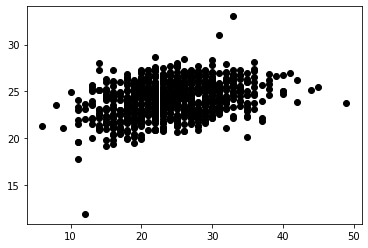

Ridge Regression for Violent Crimes
Loss: 5.631462014520 (0.130964232896)


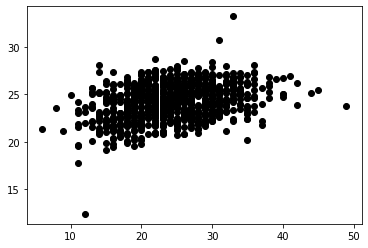

Lasso Regression for Violent Crimes
Loss: 5.410698917995 (0.125830207395)


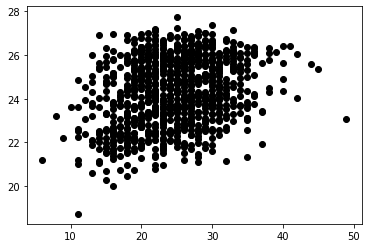

Optimized Random Forest for Violent Crimes


/home/trevorba/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/trevorba/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/trevorba/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/trevorba/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array wa

Loss: 5.318832651156 (0.123693782585)


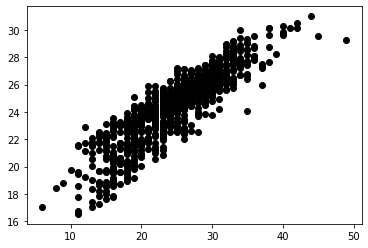

Optimized XGBoost for Violent Crimes
[12:22:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:23:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:23:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Loss: 6.318225757883 (0.146935482741)


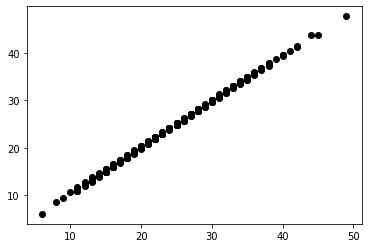

In [55]:
violent_crime_data, crimes_per_day =  ProcessCrimeDataframe(violent_crimes)
print("Violent Crimes:")
run_all_models(violent_crime_data, crimes_per_day, "Violent Crimes")

/home/trevorba/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/trevorba/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Non-violent Crimes:
Linear Regression for Non-violent Crimes
Loss: 17.097622555551 (0.129527443603)


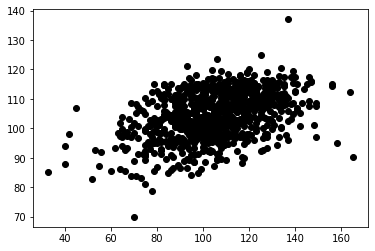

Ridge Regression for Non-violent Crimes
Loss: 17.106880995774 (0.129597583301)


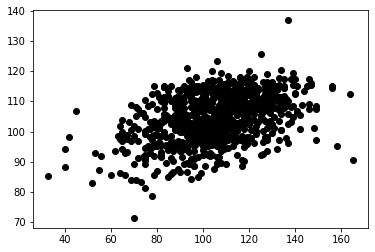

Lasso Regression for Non-violent Crimes
Loss: 16.923754707969 (0.128210262939)


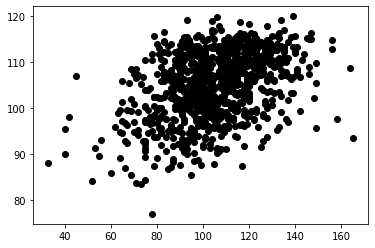

Optimized Random Forest for Non-violent Crimes


/home/trevorba/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/trevorba/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/trevorba/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/trevorba/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array wa

Loss: 17.300425206883 (0.131063827325)


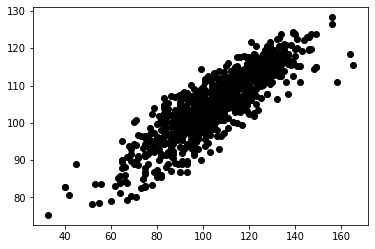

Optimized XGBoost for Non-violent Crimes
[12:23:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:23:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:23:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:23:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:23:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:23:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Loss: 17.437460865599 (0.132101976255)


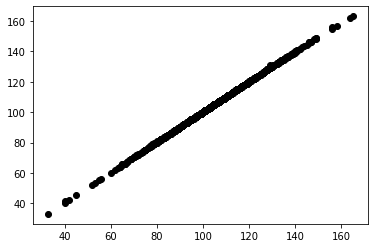

In [56]:
crime_data, crimes_per_day =  ProcessCrimeDataframe(non_violent_crimes)
print("Non-violent Crimes:")
run_all_models(crime_data, crimes_per_day, "Non-violent Crimes")

In [ ]:
def DetermineRFHyperParameters():

    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    rf_random = RandomizedSearchCV(estimator = adj_boost, 
                                      param_distributions = random_grid, 
                                      n_iter = 100, 
                                      cv = 3, 
                                      verbose=2, 
                                      random_state=42, 
                                      n_jobs = -1)

    rf = RandomForestRegressor()

    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

    print("Randomized search..")
    rf_random.fit(crimes_w_weather_expand, vcrimes_per_day)
    
    print("Best params: ")
    print(rf_random.best_params_)
    
    n_estimators = [375, 400, 425]
    min_samples_split = [1.0, 2, 3]
    min_samples_leaf = [4, 5, 6]
    max_features = ['sqrt']
    max_depth = [10,20]
    bootstrap = [True]
    grid_params = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}


    rf = RandomForestRegressor()

    grid_search = GridSearchCV(estimator = rf, 
                               param_grid = grid_params, 
                              cv = 3, n_jobs = -1, verbose = 2)

    grid_search.fit(crimes_w_weather_expand, vcrimes_per_day)

    print("Best params: ")
    print(grid_search.best_params_)

In [ ]:
def DetermineXGBHyperParameters():

    random_grid = {
            'silent': [False],
            'max_depth': [15, 17, 20, 23],
            'learning_rate': [0.05, 0.07, 0.1, 0.13, 0.15],
            'subsample': [0.8, 0.9, 1.0, 1],
            'colsample_bytree': [ 0.7, 0.8, 0.9],
            'colsample_bylevel': [0.7, 0.8, 0.9],
            'min_child_weight': [0.7, 0.9, 1.0, 1.3, 1.5, 2.0],
            'gamma': [0, 0.25, 0.5, 1.0],
            'reg_lambda': [5.0, 7, 9, 10.0, 13, 15, 20],
            'n_estimators': [100, 200, 400]}

    boost_random = RandomizedSearchCV(estimator = adj_boost, 
                                      param_distributions = random_grid, 
                                      n_iter = 100, 
                                      cv = 3, 
                                      verbose=2, 
                                      random_state=42, 
                                      n_jobs = -1)


    print("Randomized search..")
    boost_random.fit(crimes_w_weather_expand, vcrimes_per_day)

    print("Best params: ")
    print(boost_random.best_params_)
    
    grid_params = {
            'silent': [False],
            'max_depth': [ 13, 15, 17],
            'learning_rate': [0.08, 0.1,0.12,],
            'subsample': [0.6,0.7,0.8],
            'colsample_bytree': [0.8],
            'colsample_bylevel': [0.7],
            'min_child_weight': [ 1.0, 1.3, 1.5],
            'gamma': [0.25, 0.5, 1.0],
            'reg_lambda': [5],
            'n_estimators': [350, 400, 450]}
    
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = adj_boost, 
                               param_grid = grid_params, 
                              cv = 3, n_jobs = -1, verbose = 2)

    grid_search.fit(crimes_w_weather_expand, vcrimes_per_day)
    
    print("Best params: ")
    print(grid_search.best_params_)